# Affect Modeling Drift Diffusion Model

This is the data analysis file for the DDMs

## Load the Librarys

In [1]:
#JAGS & mcmc
library(rjags)
library(runjags)
load.module("wiener")
library(coda)
#Leave-One-Out Cross Validation
library(loo)

Loading required package: coda

Linked to JAGS 4.3.1

Loaded modules: basemod,bugs

module wiener loaded

This is loo version 2.6.0

- Online documentation and vignettes at mc-stan.org/loo

- As of v2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. 

- Windows 10 users: loo may be very slow if 'mc.cores' is set in your .Rprofile file (see https://github.com/stan-dev/loo/issues/94).



## Data Preprocessing

### Import Data

In [2]:
#set working directory
setwd("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/Project 3 Data Analysis Tomi/Simulation 0329")
data <- read.table("MD4 simulated data.txt", header = TRUE, sep = ",") 

### Data Visualization

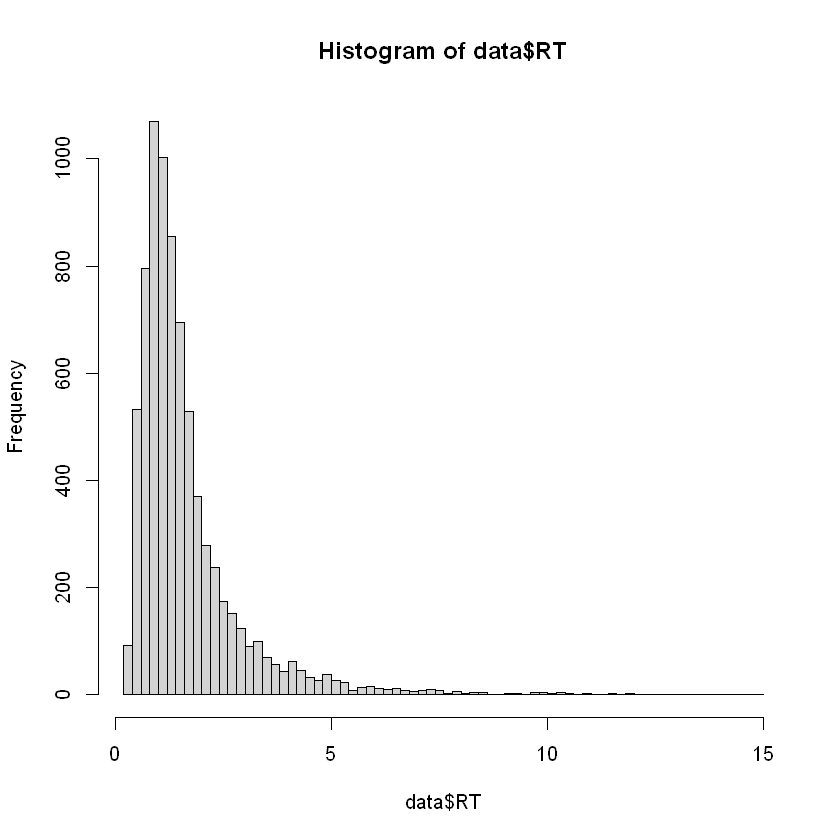

In [3]:
hist(data$RT, breaks = 100)

### Data Exclusion
All RTs greater than 5s were removed.

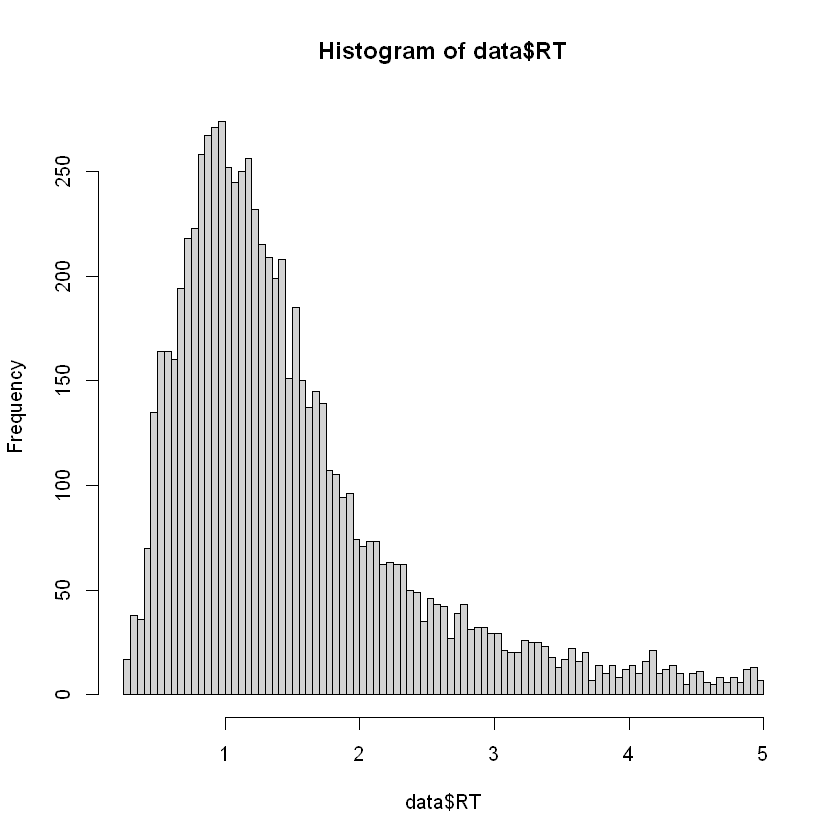

In [4]:
data <- data[data$RT <= 5, ]
hist(data$RT, breaks = 100)

### Data Reorganization

In [5]:
#the dwiener module work with a univariate distribution
#thus the RT hitting the lower boundary is flipped
data$RT[data$resp == "lower"] = -data$RT[data$resp == "lower"] 
data$R[data$resp == "lower"] = 0
data$R[data$resp == "upper"] = 1

#reorganize the data format
y = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))
Dec = matrix(NA, nrow = 193, ncol = length(unique(data$Sub)))
o.true = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))
o.win = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))
o.loss = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))
p.win = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))
p.loss = matrix(NA, nrow = 192, ncol = length(unique(data$Sub)))

for (i in 1:length(unique(data$Sub))){
  y[1:length(data$RT[data$Sub==i]),i] = data$RT[data$Sub==i]
  Dec[1,i] = 0
  Dec[(2:(1+length(data$R[data$Sub==i]))),i] = data$R[data$Sub==i]
  o.true[1:length(data$RT[data$Sub==i]),i] = data$outcome.true[data$Sub==i]
  o.win[1:length(data$RT[data$Sub==i]),i] = data$outcome.win[data$Sub==i]
  o.loss[1:length(data$RT[data$Sub==i]),i]= data$outcome.loss[data$Sub==i]
  p.win[1:length(data$RT[data$Sub==i]),i] = data$prob.win[data$Sub==i]
  p.loss[1:length(data$RT[data$Sub==i]),i] = data$prob.loss[data$Sub==i]
}

#feed the matrices to the data list
data_model=list(
  #allow for different numbers of trials
  nTrials = as.numeric(table(data$Sub)),
  nSubject = length(unique(data$Sub)),
  o.true = o.true,
  o.win = o.win,
  o.loss = o.loss,
  p.win = p.win,
  p.loss = p.loss,
  y = y,
  Dec = Dec)

## MD4

### Model Script

In [6]:
model_String ='
model {

  #likelihood function
  for (i in 1:nSubject){
  
      #sample from the logit_gamma
      gamma[i] = 2 * (1/(1+exp(-logit_gamma[i])))
                 
    for (j in 1:nTrials[i]) {
      
      #model the response bias
      p[j,i] = z0[i] + z1[i] * (gamma[i]*p.win[j,i]*o.win[j,i] +
                      (2-gamma[i])*p.loss[j,i]*o.loss[j,i]) + z_dec[i]* Dec[j,i]
      beta[j,i] = 0.8*(1/(1+exp(-p[j,i])))+0.1
      
      #model the drift rate
      delta[j,i] = v0[i] + v1[i] * (o.true[j,i] - (gamma[i]*p.win[j,i]*o.win[j,i] 
                          + (2-gamma[i])*p.loss[j,i]*o.loss[j,i])) + v_dec[i]*Dec[j,i]
  
      y[j,i] ~ dwiener(alpha[i], tau[i], beta[j,i], delta[j,i])
  
    }
  }
  
  #looic
   for (i in 1:nSubject){
    for (j in 1:nTrials[i]) {
     
     ld[j,i] = logdensity.wiener(y[j,i], alpha[i], tau[i], beta[j,i],delta[j,i])
    }
  }
  
    
  #priors
  for (i in 1:nSubject) {
    
    z_dec[i] ~ dnorm(muz_dec, precz_dec)
    z0[i] ~ dnorm(muz0, precz0)
    z1[i] ~ dnorm(muz1, precz1)
    
    v_dec[i] ~ dnorm(muv_dec, precv_dec)
    v0[i] ~ dnorm(muv0, precv0)
    v1[i] ~ dnorm(muv1, precv1)
    
    alpha[i] ~ dnorm(mualpha,precalpha)
    
    #beta distribution
    logit_gamma[i] ~ dnorm(mugamma, precgamma)
    tau[i] ~ dnorm(mutau,prectau)T(0.001, 3)
    
  }

  #hyperpriors
   
  muz_dec ~ dnorm(0, 1e-3)
  muz0 ~ dnorm(0, 1e-3)
  muz1 ~ dnorm(0, 1e-3)
  muv_dec ~ dnorm(0, 1e-3)
  muv0 ~ dnorm(0, 1e-3)
  muv1 ~ dnorm(0, 1e-3)
  mualpha ~ dunif(.1, 10) 
  mutau ~ dunif(.0001, 3)
  mugamma ~ dnorm(0, 1e-3)
  
  precz_dec ~ dgamma(.001, .001)
  precz0 ~ dgamma(.001, .001)
  precz1 ~ dgamma(.001, .001)
  precv_dec ~ dgamma(.001, .001)
  precv0 ~ dgamma(.001, .001)
  precv1 ~ dgamma(.001, .001)
  precalpha  ~ dgamma(.001, .001)
  prectau ~ dgamma(.001, .001)
  precgamma ~ dgamma(.001,.001)
}

'

writeLines(model_String, con = 'Model D4.txt')

#init function
initfunction <- function(chain){
  return(list(
    muv_dec = runif(1, -.2, .2),
    muv0 = runif(1, -1, 2),
    muv1 = runif(1, -1, 1),
    muz_dec = runif(1, -1, 1),
    muz0 = runif(1, -1, 1),
    muz1 = runif(1, -1, 1),
    mugamma = runif(1, 0.01, 1.89),
    mualpha = runif(1, .8, 4.9),
    mutau  = runif(1, .001, .50),
    precv_dec = runif(1, 1, 100),
    precv0 = runif(1, 1, 100),
    precv1 = runif(1, 1, 100),
    precz_dec = runif(1, 1, 100),
    precz0 = runif(1, 1, 100),
    precz1 = runif(1, 1, 100),
    precalpha = runif(1, 1, 100),
    prectau   = runif(1, 1, 100),
    precgamma = runif(1, 1, 100),
    y = matrix(NA,nrow = 192, ncol = data_model$nSubject),
    .RNG.name = "lecuyer::RngStream",
    .RNG.seed = sample.int(1e10, 1, replace = F)))
}
  

#Create list of parameters to be monitored
parameters <- c("alpha", "tau", "z_dec", "z0", "z1", "v_dec", "v0","v1","gamma",
                "mualpha", "mutau", "muz_dec", "muz0", "muz1", "muv_dec", "muv0","muv1","mugamma",
                "precalpha", "prectau", "precz_dec", "precz0", "precz1", "precv_dec", "precv0","precv1","precgamma",
                "ld")



### Run the MD4

In [7]:
#Run the model in runjags
startTime = proc.time()
jagsModel <- run.jags(method = "parallel",
                      model = 'Model D4.txt',
                      monitor = parameters,
                      data = data_model,
                      inits = initfunction,
                      n.chains = 8,
                      adapt = 1000, #how long the samplers "tune"
                      burnin = 1000, #how long of a burn in
                      sample = 1000,
                      thin = 3, #thin if high autocorrelation to avoid huge files
                      modules = c("wiener", "lecuyer"),
                      summarise = F,
                      plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis


Calling 8 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Fri Apr  5 14:48:55 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: wiener: ok
. Loading module: lecuyer: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 7466
   Unobserved stochastic nodes: 378
   Total graph size: 68398
. Reading parameter file inits1.txt
. Initializing model
. Adapting 1000
-------------------------------------------------| 1000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation successful
. Updating 1000
-------------------------------------------------| 1000
************************************************** 100%
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . Updati

ERROR: Error in runjags.readin(directory = startinfo$directory, silent.jags = silent.jags, : Simulation numbers 2, 3, 5, 8 appear to have crashed; check the output in failed.jags() for clues


Note: Either one or more simulation(s) failed, or there was an error in
processing the results.  You may be able to retrieve any successful
simulations using:
results.jags("C:/Users/u0145642/AppData/Local/Temp/RtmpWMRfZb/runjagsfiles84785feb271",
recover.chains=TRUE)
See the help file for that function for possible options.
To remove failed simulation folders use cleanup.jags() - this will be
run automatically when the runjags package is unloaded


In [9]:
jagsMD4 = results.jags("C:/Users/u0145642/AppData/Local/Temp/RtmpWMRfZb/runjagsfiles84785feb271",
recover.chains=TRUE)

Note: the model did not require adaptation


Warning message in runjags.readin(directory = runjags.object$directory, silent.jags = runjags.object$silent.jags, :
"Chains 2, 3, 5, 8 (simulations 2, 3, 5, 8) appear to have crashed and will not be imported; check the output in failed.jags() for clues"


Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


### Save/ Load MD4

In [10]:
save(jagsMD4, file = "jagsMD4.RData")
#load("jags_sample_MD4.RData")

### Posterior Samples and Posterior Means in MD4

In [28]:
num_chain = length(jagsMD4[[1]])
name_parameters = c("alpha", "tau", "z_dec","z0","z1","v_dec","v0","v1","gamma")
posterior_samples_names = paste("mu",name_parameters, sep = "")
posterior_samples = setNames(replicate(length(posterior_samples_names), c(NULL), simplify = FALSE), posterior_samples_names)

for (name in posterior_samples_names){
  for (i in 1:num_chain){
    posterior_samples_one_chain = as.numeric(jagsMD4[[1]][[i]][,grep(paste("^",name,sep=""), colnames(jagsMD4[[1]][[i]]))])
    posterior_samples[[name]] = rbind(posterior_samples[[name]],posterior_samples_one_chain)
  }
}

mcmcMat = as.matrix(jagsMD4[[1]], chains = F)
quantiles = apply(mcmcMat, 2, function(x) quantile(x, c(0.025, 0.975)))
posterior_mean =  colMeans(mcmcMat)

### Marginal Posterior Visualization of hyper priors

<environment: R_GlobalEnv>

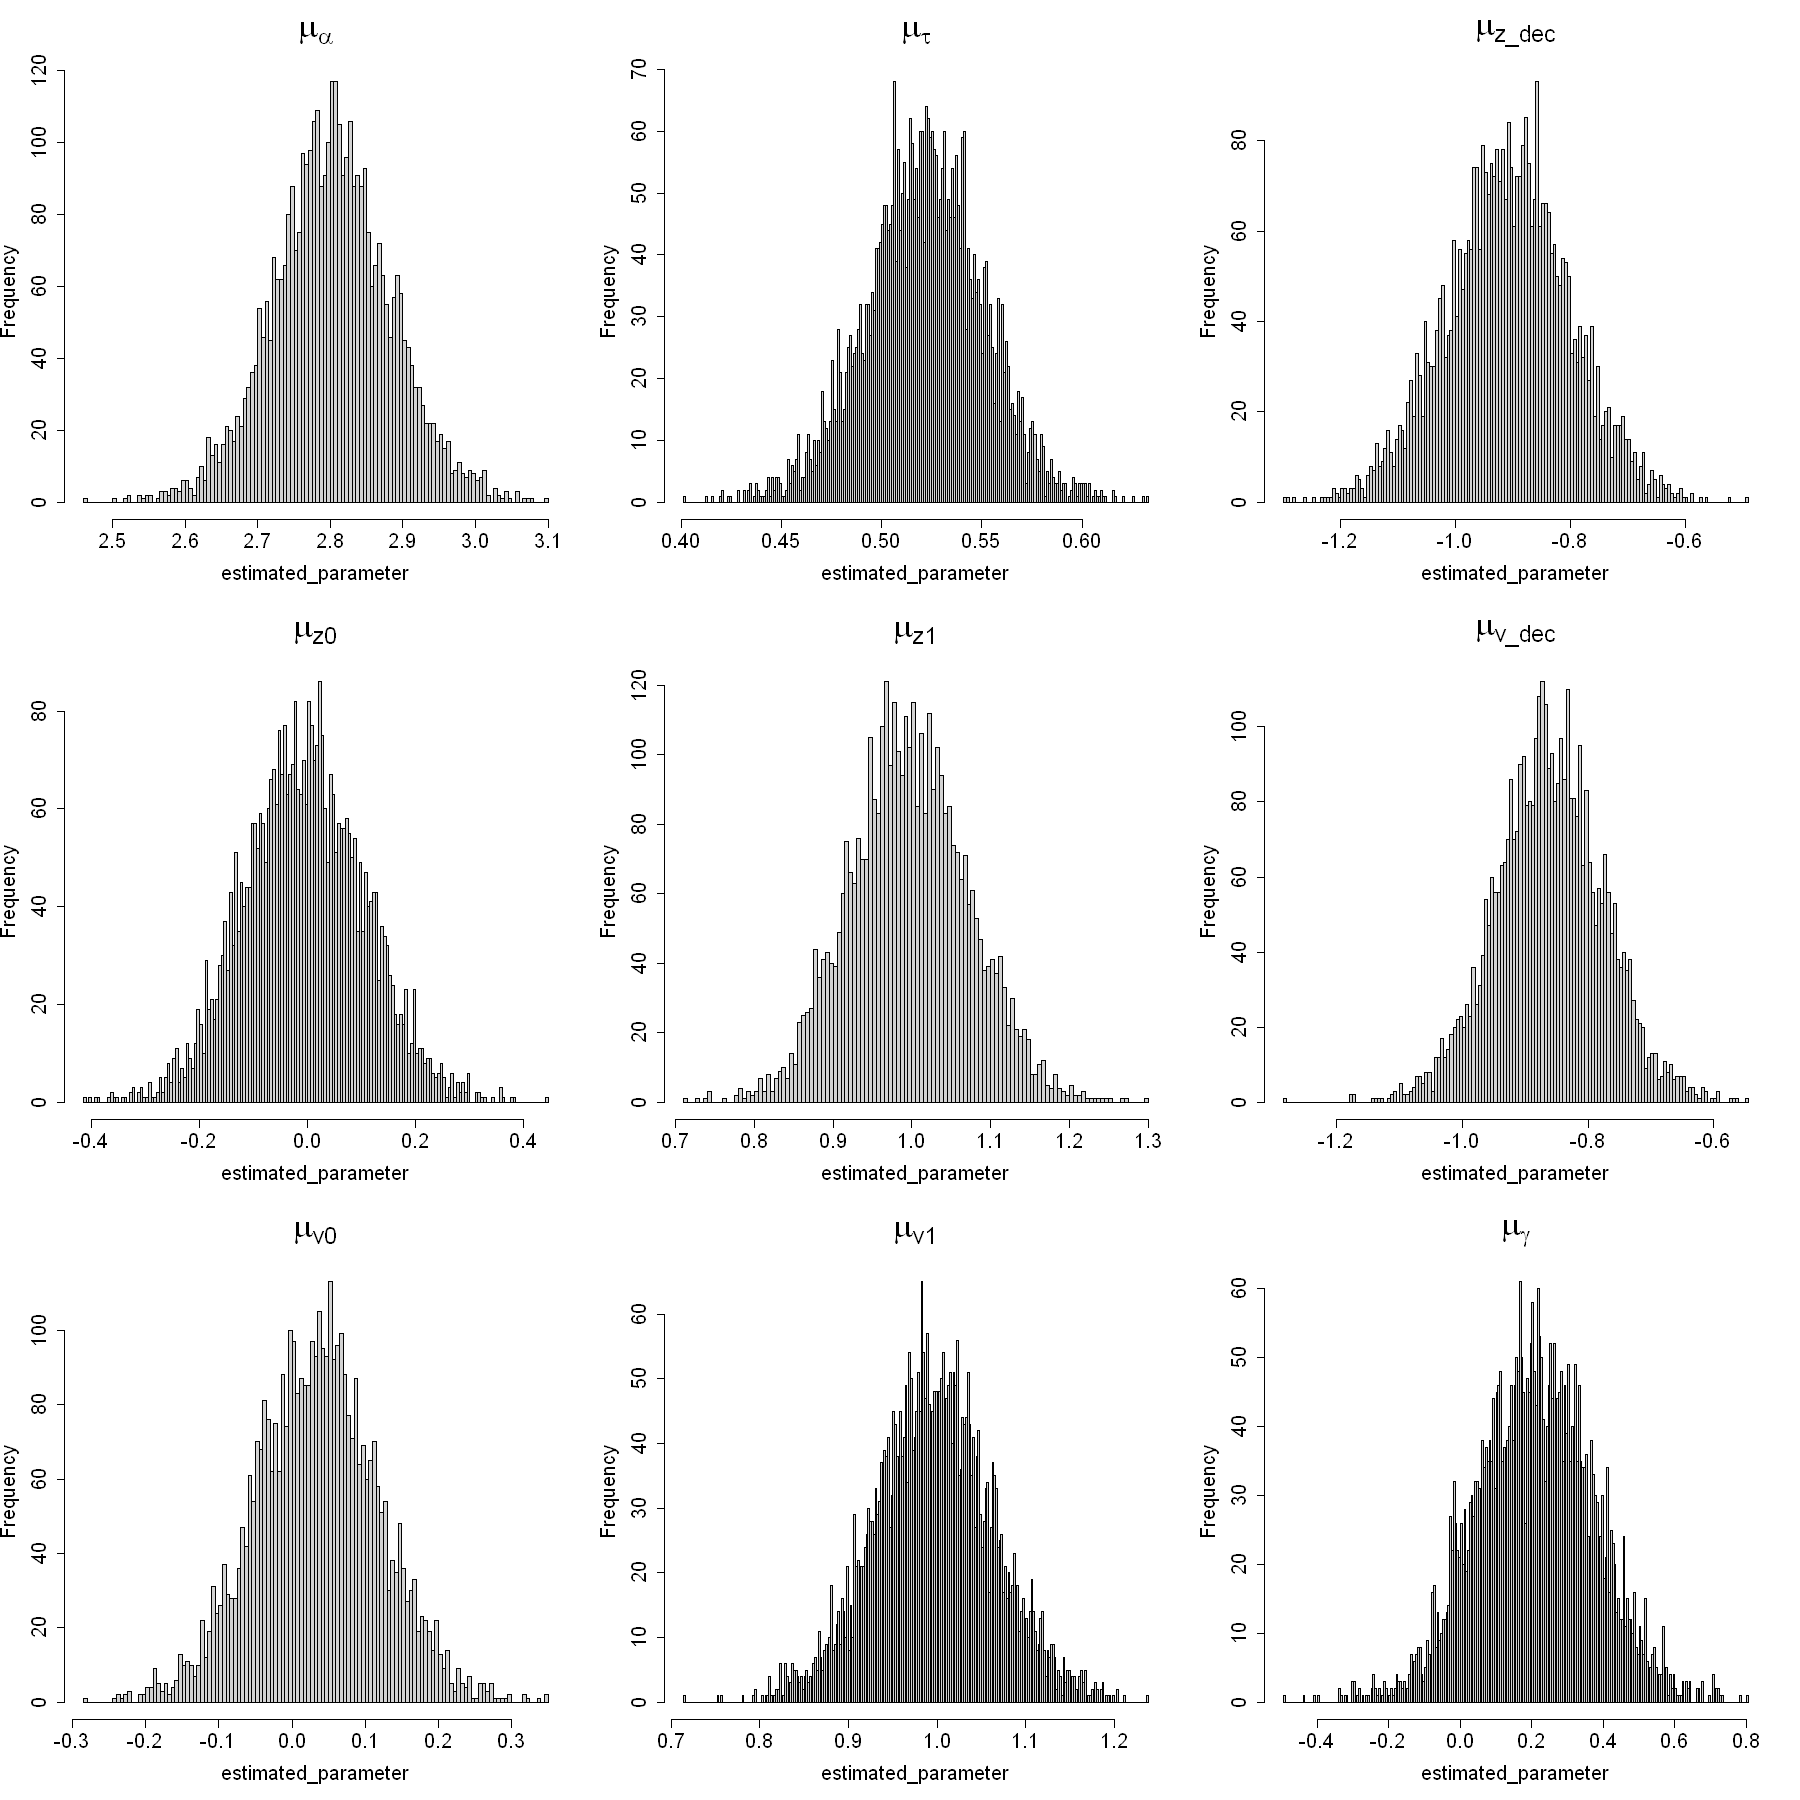

In [34]:
list2env(posterior_samples, envir = .GlobalEnv)
par(mfrow = c(3, 3))
options(repr.plot.width=15, repr.plot.height=15)  
for (name in name_parameters){
  estimated_parameter= get(paste("mu",name, sep = ""))
  hist(estimated_parameter, main=bquote(mu[.(as.name(name))]),pch=16,cex.main=2.5,cex.axis = 1.5,cex.lab = 1.5, breaks =200)
}

### Leave-One-Out Cross Validation

In [44]:
#get the log density
ld = (as.matrix(jagsMD4[[1]][[1]][,grep("^ld", colnames(jagsMD4[[1]][[1]]))])+
      as.matrix(jagsMD4[[1]][[2]][,grep("^ld", colnames(jagsMD4[[1]][[2]]))])+
      as.matrix(jagsMD4[[1]][[3]][,grep("^ld", colnames(jagsMD4[[1]][[3]]))])+
      as.matrix(jagsMD4[[1]][[4]][,grep("^ld", colnames(jagsMD4[[1]][[4]]))]))/4

loo(ld)

Warning message:
"Relative effective sample sizes ('r_eff' argument) not specified.
For models fit with MCMC, the reported PSIS effective sample sizes and 
MCSE estimates will be over-optimistic."
Warning message:
"Some Pareto k diagnostic values are slightly high. See help('pareto-k-diagnostic') for details.
"



Computed from 1000 by 7466 log-likelihood matrix

         Estimate    SE
elpd_loo  -5752.2 114.2
p_loo        72.2   1.9
looic     11504.5 228.3
------
Monte Carlo SE of elpd_loo is 0.3.

Pareto k diagnostic values:
                         Count Pct.    Min. n_eff
(-Inf, 0.5]   (good)     7464  100.0%  464       
 (0.5, 0.7]   (ok)          2    0.0%  377       
   (0.7, 1]   (bad)         0    0.0%  <NA>      
   (1, Inf)   (very bad)    0    0.0%  <NA>      

All Pareto k estimates are ok (k < 0.7).
See help('pareto-k-diagnostic') for details.

### Hypothesis Testing
The hypothesis here is whether $\gamma = 1$

In [45]:
t.test(mugamma, mu = 0)


	One Sample t-test

data:  mugamma
t = 78.674, df = 3999, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.2020400 0.2123671
sample estimates:
mean of x 
0.2072035 


In [46]:
t.test(posterior_mean[grep("^gamma.*$", names(posterior_mean))], mu = 0)


	One Sample t-test

data:  posterior_mean[grep("^gamma.*$", names(posterior_mean))]
t = 19.862, df = 39, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.9761479 1.1975123
sample estimates:
mean of x 
  1.08683 
